### Plate Velocities

This notebook goes through steps to generate plate velocities (assuming that you have a topological plate model)

In [3]:
import pygplates
import numpy as np

def make_GPML_velocity_feature(Long,Lat):
# function to make a velocity mesh nodes at an arbitrary set of points defined in Lat
# Long and Lat are assumed to be 1d arrays. 
# Filename should have extension .gpml or .gpmlz

    # Add points to a multipoint geometry
    SeedPoints = zip(Lat,Long)
    points = []
    for j in range(0,len(SeedPoints)):
        points.append(SeedPoints[j])
    multi_point = pygplates.MultiPointOnSphere(points)

    # Create a feature containing the multipoint feature, and defined as MeshNode type
    meshnode_feature = pygplates.Feature(pygplates.FeatureType.create_from_qualified_string('gpml:MeshNode'))
    meshnode_feature.set_geometry(multi_point)
    meshnode_feature.set_name('Velocity Mesh Nodes from pygplates')

    output_feature_collection = pygplates.FeatureCollection(meshnode_feature)
    
    # NB: at this point, the feature could be written to a file using
    # output_feature_collection.write('filename.gpml')
    
    return output_feature_collection

    
    
#######
# Run test case
# Generate points for regular long,lat grid
Xnodes = np.arange(-180,180,5)
Ynodes = np.arange(-90,90,5)
Xg,Yg = np.meshgrid(Xnodes,Ynodes)
Xg = Xg.flatten()
Yg = Yg.flatten()

velocity_domain_features = make_GPML_velocity_feature(Xg,Yg)



In [65]:

rotation_filename = '/Users/Simon/GIT/pygplates-alpha/tutorials-sv/Data/Seton_etal_ESR2012_2012.1.rot'

input_topology_filename = '/Users/Simon/GIT/pygplates-alpha/tutorials-sv/Data/Seton_etal_ESR2012_PP_2012.1.gpmlz'

# Load one or more rotation files into a rotation model.
rotation_model = pygplates.RotationModel(rotation_filename)

# Load the topological plate polygon features.
topology_features = pygplates.FeatureCollection(input_topology_filename)

# Load the features that contain the geometries we will calculate velocities at.
# These can be generated in GPlates via the menu 'Features > Generate Velocity Domain Points'.
#velocity_domain_features = pygplates.FeatureCollection(velocity_domain_file)

# Calculate velocities using a delta time interval of 1My.
delta_time = 5

# Our geological times will be from 0Ma to 'num_time_steps' Ma (inclusive) in 1 My intervals.
num_time_steps = 10

# 'time' = 0, 1, 2, ... , 140
for time in range(num_time_steps + 1):

    print 'Time: %d' % time

    # All domain points and associated (magnitude, azimuth, inclination) velocities for the current time.
    all_domain_points = {}
    all_velocities = {}

    # Partition our velocity domain features into our topological plate polygons at the current 'time'.
    # Note that we don't copy plate IDs - we rely on the returned partition grouping instead.
    partitioned_domain_feature_groups, unpartitioned_domain_features = pygplates.partition_into_plates(
        topology_features,
        rotation_model,
        velocity_domain_features,
        # We'll get plate ID directly from partitioning plate instead of assigned plate ID in partitioned feature...
        properties_to_copy = [],
        reconstruction_time = time,
        partition_return = pygplates.PartitionReturn.partitioned_groups_and_unpartitioned)

    for partitioning_plate, partitioned_domain_features in partitioned_domain_feature_groups:

        # All domain points and associated velocities in the current partitioning plate.
        all_domain_points_in_partitioning_plate = []
        all_velocities_in_partitioning_plate = []

        # We need the partitioning plate ID to get the equivalent stage rotation of that tectonic plate.
        partitioning_plate_id = partitioning_plate.get_feature().get_reconstruction_plate_id()

        # Get the stage rotation of partitioning plate from 'time + delta_time' to 'time'.
        equivalent_stage_rotation = rotation_model.get_rotation(time, partitioning_plate_id, time + delta_time)

        for partitioned_domain_feature in partitioned_domain_features:

            # A velocity domain feature usually has a single geometry but we'll assume it can be any number.
            # Iterate over them all.
            for partitioned_domain_geometry in partitioned_domain_feature.get_geometries():

                partitioned_domain_points = partitioned_domain_geometry.get_points()

                # Calculate velocities at the velocity domain geometry points.
                # This is from 'time + delta_time' to 'time' on the partitioning plate.
                partitioned_domain_velocity_vectors = pygplates.calculate_velocities(
                    partitioned_domain_points,
                    equivalent_stage_rotation,
                    delta_time)

                # Convert global 3D velocity vectors to local (magnitude, azimuth, inclination) tuples (one tuple per point).
                partitioned_domain_velocities = pygplates.LocalCartesian.convert_from_geocentric_to_magnitude_azimuth_inclination(
                        partitioned_domain_points,
                        partitioned_domain_velocity_vectors)

                # Append results for the current geometry to the final results.
                all_domain_points_in_partitioning_plate.extend(partitioned_domain_points)
                all_velocities_in_partitioning_plate.extend(partitioned_domain_velocities)

        all_domain_points[partitioning_plate_id] = all_domain_points_in_partitioning_plate
        all_velocities[partitioning_plate_id] = all_velocities_in_partitioning_plate
        
print all_velocities


Time: 0
Time: 1
Time: 2
Time: 3
Time: 4
Time: 5
Time: 6
Time: 7
Time: 8
Time: 9
Time: 10
{278: [(29.044254627295885, 3.9080893136226105, 6.116035209699699e-17)], 903: [(22.25005656131252, 0.9136203492968865, -3.9918029747594136e-17), (22.438511366427413, 0.9582844564585741, -7.916553867553097e-17), (21.84080140549818, 0.8990801473769895, 0.0), (22.07553724520715, 0.946683447292906, 4.0233603822845075e-17), (21.33588773662488, 0.8801212433639677, 0.0)], 909: [(135.35894682964926, 0.9940866331469705, 0.0), (144.04580749848333, 0.9070810754520394, 0.0), (153.24067454422993, 0.8337309761305228, 0.0), (122.54187819640704, 0.9244167863491153, 7.247958271674073e-18), (132.53322994620083, 0.8371787701223423, -6.701552660119e-18), (142.97812586968678, 0.766474388296018, 0.0), (153.51186766598022, 0.7094891458313042, 0.0), (163.8411074132525, 0.6637547664320242, 1.084194844288856e-17), (109.90309013430712, 0.8344781765118413, 1.6162938068706283e-17), (121.27681937177914, 0.7499736283468709, 0.0)

In [66]:
import pygplates

rotation_filename = '/Users/Simon/GIT/pygplates-alpha/tutorials-sv/Data/Seton_etal_ESR2012_2012.1.rot'

input_topology_filename = '/Users/Simon/GIT/pygplates-alpha/tutorials-sv/Data/Seton_etal_ESR2012_PP_2012.1.gpmlz'


# Load one or more rotation files into a rotation model.
rotation_model = pygplates.RotationModel(rotation_filename)

# Load the topological plate polygon features.
topology_features = pygplates.FeatureCollection(input_topology_filename)


# Calculate velocities using a delta time interval of 1My.
delta_time = 1

# Our geological times will be from 0Ma to 'num_time_steps' Ma (inclusive) in 1 My intervals.
num_time_steps = 1

# 'time' = 0, 1, 2, ... , 140
for time in range(num_time_steps + 1):

    print 'Time: %d' % time

    # All domain points and associated (magnitude, azimuth, inclination) velocities for the current time.
    all_domain_points = []
    all_velocities = []

    # Partition our velocity domain features into our topological plate polygons at the current 'time'.
    plate_partitioner = pygplates.PlatePartitioner(topology_features, rotation_model, time)

    for velocity_domain_feature in velocity_domain_features:

        # A velocity domain feature usually has a single geometry but we'll assume it can be any number.
        # Iterate over them all.
        for velocity_domain_geometry in velocity_domain_feature.get_geometries():

            for velocity_domain_point in velocity_domain_geometry.get_points():

                all_domain_points.append(velocity_domain_point)

                partitioning_plate = plate_partitioner.partition_point(velocity_domain_point)
                if partitioning_plate:

                    # We need the newly assigned plate ID to get the equivalent stage rotation of that tectonic plate.
                    partitioning_plate_id = partitioning_plate.get_feature().get_reconstruction_plate_id()

                    # Get the stage rotation of partitioning plate from 'time + delta_time' to 'time'.
                    equivalent_stage_rotation = rotation_model.get_rotation(time, partitioning_plate_id, time + delta_time)

                    # Calculate velocity at the velocity domain point.
                    # This is from 'time + delta_time' to 'time' on the partitioning plate.
                    velocity_vectors = pygplates.calculate_velocities(
                        [velocity_domain_point],
                        equivalent_stage_rotation,
                        delta_time)

                    # Convert global 3D velocity vectors to local (magnitude, azimuth, inclination) tuples (one tuple per point).
                    velocities = pygplates.LocalCartesian.convert_from_geocentric_to_magnitude_azimuth_inclination(
                            [velocity_domain_point],
                            velocity_vectors)
                    all_velocities.append(velocities[0])

                else:
                    all_velocities.append((0,0,0))
    
pt_vel_mag=[]
pt_vel_az=[]
for vel in all_velocities:
    pt_vel_mag.append(vel[0])
    pt_vel_az.append(vel[1])


pt_lon = []
pt_lat = []
for pt in all_domain_points:
    pt_lon.append(pt.to_lat_lon()[1])
    pt_lat.append(pt.to_lat_lon()[0])


Time: 0
Time: 1


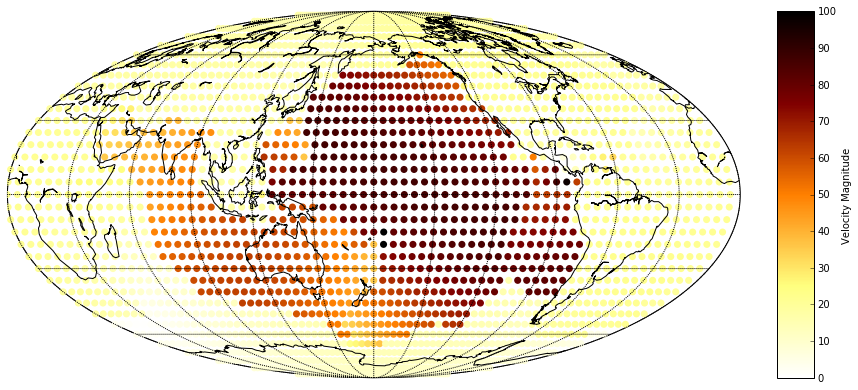

In [67]:
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap, shiftgrid

%matplotlib inline

fig = plt.figure(figsize=(14,10),dpi=150)
ax_map = fig.add_axes([0,0,0.8,1.0])
#ax_cbr = fig.add_axes([0.91,0.3,0.01,0.4])
# set up map
m = Basemap(projection='moll', lon_0=180, resolution='c', ax=ax_map)
cp = m.drawmapboundary()
m.drawcoastlines()
m.drawparallels(np.arange(-90,90,30))
m.drawmeridians(np.arange(-180,180,30))

x,y = m(pt_lon,pt_lat)
im = m.scatter(x,y,c=pt_vel_mag,edgecolor='',s=50,cmap=plt.cm.afmhot_r,vmin=0,vmax=100)

# add colorbar.
cbar = m.colorbar(im,location='right',pad="5%")
cbar.set_label('Velocity Magnitude')

plt.show()

#plt.figure(figsize=(8,10))
#plt.subplot(211)
#plt.scatter(pt_lon,pt_lat,c=pt_vel_mag,edgecolor='',s=25)
#plt.subplot(212)
#plt.scatter(pt_lon,pt_lat,c=pt_vel_az,edgecolor='',s=25,cmap=plt.cm.hsv)
#plt.show()


### Plotting velocity vectors using basemap

Basemap can plot velocity vectors, for which we need the north and east components of the velocity vector.

The code below shows how to access these values. Note the (potentially confusing) notation that GPlates uses for converting x and y directions to Long/Lat. 


In [68]:
import pygplates
import numpy as np

rotation_filename = '/Users/Simon/GIT/pygplates-alpha/tutorials-sv/Data/Seton_etal_ESR2012_2012.1.rot'

input_topology_filename = '/Users/Simon/GIT/pygplates-alpha/tutorials-sv/Data/Seton_etal_ESR2012_PP_2012.1.gpmlz'

# Load one or more rotation files into a rotation model.
rotation_model = pygplates.RotationModel(rotation_filename)

# Load the topological plate polygon features.
topology_features = pygplates.FeatureCollection(input_topology_filename)

# Calculate velocities using a delta time interval of 1My.
delta_time = 1

# Our geological times will be from 0Ma to 'num_time_steps' Ma (inclusive) in 1 My intervals.
num_time_steps = 10

# 'time' = 0, 1, 2, ... , 140
time = 10

# All domain points and associated (magnitude, azimuth, inclination) velocities for the current time.
all_domain_points = []
all_velocities = []

# Partition our velocity domain features into our topological plate polygons at the current 'time'.
plate_partitioner = pygplates.PlatePartitioner(topology_features, rotation_model, time)

for velocity_domain_feature in velocity_domain_features:

    # A velocity domain feature usually has a single geometry but we'll assume it can be any number.
    # Iterate over them all.
    for velocity_domain_geometry in velocity_domain_feature.get_geometries():

        for velocity_domain_point in velocity_domain_geometry.get_points():

            all_domain_points.append(velocity_domain_point)

            partitioning_plate = plate_partitioner.partition_point(velocity_domain_point)
            if partitioning_plate:

                # We need the newly assigned plate ID to get the equivalent stage rotation of that tectonic plate.
                partitioning_plate_id = partitioning_plate.get_feature().get_reconstruction_plate_id()

                # Get the stage rotation of partitioning plate from 'time + delta_time' to 'time'.
                equivalent_stage_rotation = rotation_model.get_rotation(time, partitioning_plate_id, time + delta_time)

                # Calculate velocity at the velocity domain point.
                # This is from 'time + delta_time' to 'time' on the partitioning plate.
                velocity_vectors = pygplates.calculate_velocities(
                    [velocity_domain_point],
                    equivalent_stage_rotation,
                    delta_time)

                # Convert global 3D velocity vectors to local (magnitude, azimuth, inclination) tuples (one tuple per point).
                velocities = pygplates.LocalCartesian.convert_from_geocentric_to_north_east_down(
                        [velocity_domain_point],
                        velocity_vectors)
                all_velocities.append(velocities[0])

            else:
                all_velocities.append((0,0,0))

# Note about units:
# The strain_sphere function expects metres / year
# pygplates defaults to velocities in km/Myr
# therefore, we here divide by 1000 to make plate velocities consistent with strain calc. 
pt_vel_n=[]
pt_vel_e=[]
for vel in all_velocities:
    pt_vel_e.append(vel.get_y())
    pt_vel_n.append(vel.get_x())


pt_lon = []
pt_lat = []
for pt in all_domain_points:
    pt_lon.append(pt.to_lat_lon()[1])
    pt_lat.append(pt.to_lat_lon()[0])


u = np.asarray(pt_vel_e).reshape((Ynodes.shape[0],Xnodes.shape[0]))
v = np.asarray(pt_vel_n).reshape((Ynodes.shape[0],Xnodes.shape[0]))

print Xnodes.shape[0]
print Ynodes.shape[0]
print u.shape
print v.shape


72
36
(36, 72)
(36, 72)


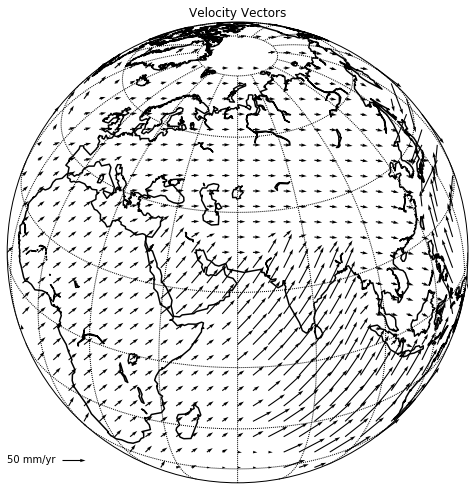

In [69]:
m = Basemap(resolution='c',projection='ortho',lat_0=30.,lon_0=60.)
# create figure, add axes
fig1 = plt.figure(figsize=(8,10))
ax = fig1.add_axes([0.1,0.1,0.8,0.8])

lons, lats = np.meshgrid(Xnodes,Ynodes)
# compute native x,y coordinates of grid.
x, y = m(lons, lats)
# define parallels and meridians to draw.
parallels = np.arange(-80.,90,20.)
meridians = np.arange(0.,360.,20.)
# plot SLP contours.
# plot wind vectors on projection grid.
# first, shift grid so it goes from -180 to 180 (instead of 0 to 360
# in longitude).  Otherwise, interpolation is messed up.
#ugrid,newlons = shiftgrid(180.,np.asarray(pt_vel_e),np.asarray(pt_lon),start=False)
#vgrid,newlons = shiftgrid(180.,np.asarray(pt_vel_n),np.asarray(pt_lon),start=False)
# transform vectors to projection grid.
uproj,vproj,xx,yy = \
m.transform_vector(u,v,Xnodes,Ynodes,31,31,returnxy=True,masked=True)
# now plot.
Q = m.quiver(xx,yy,uproj,vproj,scale=1000)
# make quiver key.
qk = plt.quiverkey(Q, 0.12, 0.05, 50, '50 mm/yr', labelpos='W')
# draw coastlines, parallels, meridians.
m.drawcoastlines(linewidth=1.5)
m.drawparallels(parallels)
m.drawmeridians(meridians)
# add colorbar
# set plot title
ax.set_title('Velocity Vectors')
plt.show()

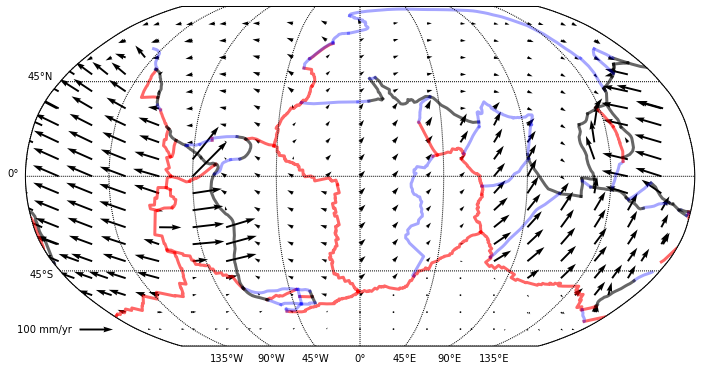

In [70]:

topology_features = pygplates.FeatureCollection(input_topology_filename)
rotation_model = pygplates.RotationModel(rotation_filename)

# Create the basemap
fig = plt.figure(figsize=(12,8),dpi=300)
pmap = Basemap(resolution='c',projection='robin',lon_0=0.)
#pmap = Basemap(resolution='c',projection='ortho',lat_0=30.,lon_0=60.)
clip_path = pmap.drawmapboundary()
#pmap.drawmapboundary(fill_color='lightblue')
pmap.drawmeridians(np.arange(0, 360, 45), labels=[0,0,0,1],fontsize=10)
pmap.drawparallels(np.arange(-90, 90, 45), labels=[1,0,0,0],fontsize=10)
ax = plt.gca()

# Resolve our topological plate polygons (and deforming networks) to the current 'time'.
# We generate both the resolved topology boundaries and the boundary sections between them.
resolved_topologies = []
shared_boundary_sections = []
pygplates.resolve_topologies(topology_features, rotation_model, resolved_topologies, time, shared_boundary_sections)

# create a dateline wrapper object
wrapper = pygplates.DateLineWrapper(0.)

# Iterate over the shared boundary sections.
for shared_boundary_section in shared_boundary_sections:

    # The shared sub-segments contribute either to the ridges or to the subduction zones.
    if shared_boundary_section.get_feature().get_feature_type() == pygplates.FeatureType.create_gpml('MidOceanRidge'):
        # Ignore zero length segments - they don't have a direction.
        for shared_sub_segment in shared_boundary_section.get_shared_sub_segments():
            split_geometry = wrapper.wrap(shared_sub_segment.get_geometry())
            for geometry in split_geometry:
                X=[]
                Y=[]
                for point in geometry.get_points():
                    X.append(point.get_longitude()),Y.append(point.get_latitude())
                x,y = pmap(X,Y)
                pmap.plot(x,y,'r',clip_path=clip_path,linewidth=3,alpha=0.6, zorder=1)     

    elif shared_boundary_section.get_feature().get_feature_type() == pygplates.FeatureType.create_gpml('SubductionZone'):
        for shared_sub_segment in shared_boundary_section.get_shared_sub_segments():
            split_geometry = wrapper.wrap(shared_sub_segment.get_geometry())
            for geometry in split_geometry:
                X=[]
                Y=[]
                for point in geometry.get_points():
                    X.append(point.get_longitude()),Y.append(point.get_latitude())
                x,y = pmap(X,Y)
            pmap.plot(x,y,'k',clip_path=clip_path,linewidth=3,alpha=0.6, zorder=1)  

    else: #shared_boundary_section.get_feature().get_feature_type() == pygplates.FeatureType.create_gpml('FractureZone'):
        for shared_sub_segment in shared_boundary_section.get_shared_sub_segments():
            split_geometry = wrapper.wrap(shared_sub_segment.get_geometry())
            for geometry in split_geometry:
                X=[]
                Y=[]
                for point in geometry.get_points():
                    X.append(point.get_longitude()),Y.append(point.get_latitude())
                x,y = pmap(X,Y)
            pmap.plot(x,y,'b',clip_path=clip_path,linewidth=3,alpha=0.35, zorder=1)  

lons, lats = np.meshgrid(Xnodes,Ynodes)
# compute native x,y coordinates of grid.
x, y = pmap(lons, lats)
# define parallels and meridians to draw.
parallels = np.arange(-80.,90,20.)
meridians = np.arange(0.,360.,20.)
# plot SLP contours.
# plot wind vectors on projection grid.
# first, shift grid so it goes from -180 to 180 (instead of 0 to 360
# in longitude).  Otherwise, interpolation is messed up.
#ugrid,newlons = shiftgrid(180.,np.asarray(pt_vel_e),np.asarray(pt_lon),start=False)
#vgrid,newlons = shiftgrid(180.,np.asarray(pt_vel_n),np.asarray(pt_lon),start=False)
# transform vectors to projection grid.
uproj,vproj,xx,yy = \
pmap.transform_vector(u,v,Xnodes,Ynodes,21,21,returnxy=True,masked=True)
# now plot.
Q = pmap.quiver(xx,yy,uproj,vproj,scale=2000,clip_path=clip_path)
Q2 = pmap.quiver(xx,yy,uproj,vproj,scale=2000,color='')
# make quiver key.
qk = plt.quiverkey(Q2, 0.08, 0.05, 100, '100 mm/yr', labelpos='W',color='k')

plt.show()
    